In [35]:
import sys
!{sys.executable} -m pip install -U imbalanced-learn

In [2]:
import os
import numpy as np
import pandas as pd
from scipy import stats

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import yellowbrick as yb
from matplotlib.colors import ListedColormap
from yellowbrick.classifier import ROCAUC
from matplotlib_venn import venn3
import matplotlib.patches as mpatches
# Statistics, EDA, metrics libraries
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.compose import ColumnTransformer

# Modeling libraries
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_predict,KFold, cross_validate
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours, RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.metrics import SCORERS
from numpy import argmax
import pickle
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score, recall_score, precision_score, roc_auc_score, f1_score

import json

In [3]:
%cd /mnt/home/d.alvarez/Documents/Internship/

print("File location using os.getcwd():", os.getcwd())

/mnt/home/d.alvarez/Documents/Internship
File location using os.getcwd(): /mnt/home/d.alvarez/Documents/Internship


In [4]:
data = pd.read_csv("data/training_data/final_training_set.csv")

#data = data[data.conformation_type.isin(classes)]

data.reset_index(drop=True, inplace=True)

residue_info = data[['pdb_id','asymID','compID', 'insCode', 'seqNum', 'seqID_besttls']]
conformation_type = data['conformation_type']
#df = data.drop(["conformation_type",'asymID','compID', 'insCode', 'seqNum', 'seqID_besttls','index'], axis=1)
df = data.loc[:, 'cn_m1':'dssp_p2T']
#df = df.iloc[:, 0:80]

conformation_type

/tmp/ipykernel_1203470/2747474432.py:1: DtypeWarning: Columns (150) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/training_data/final_training_set.csv")


0           random
1           random
2         pep_flip
3           random
4           random
            ...   
249204      random
249205      random
249206      random
249207      random
249208      random
Name: conformation_type, Length: 249209, dtype: object

In [5]:
labelencoder = LabelEncoder()

conformation_type_encoded = pd.Series(labelencoder.fit_transform(conformation_type), name = "encoded_label")

label_conformation = pd.concat([conformation_type, conformation_type_encoded], axis=1)

label = pd.concat([label_conformation,residue_info], axis=1)

unique_label = label_conformation.drop_duplicates(ignore_index=True)

RANDOM_STATE = 42

unique_label



,conformation_type,encoded_label
0,random,3
1,pep_flip,2
2,o_flip,1
3,n_flip,0


In [6]:
X = df
X_train, X_test, y_train_info, y_test_info = train_test_split(X, label, test_size=0.25, random_state = RANDOM_STATE, stratify=label["encoded_label"])


y_train_info['encoded_label_binary'] = y_train_info["encoded_label"].apply(lambda x: 0 if x < 3 else 1)
y_test_info['encoded_label_binary'] = y_test_info["encoded_label"].apply(lambda x: 0 if x < 3 else 1)

y_train = y_train_info["encoded_label"].array
y_test = y_test_info["encoded_label"].array


In [19]:
scaler = StandardScaler()
scaler.fit_transform(X_train[['imp_p1','imp_p2','bn_m1']])

array([[ 0.27406256, -0.18727737, -0.20300534],
       [-0.13224708, -0.07557792,  0.35913662],
       [ 0.22371392, -0.00798038,  1.22134519],
       ...,
       [-0.47837419,  0.01920627,  0.1757277 ],
       [-0.51672807,  0.25279006, -0.39976274],
       [-0.19529007,  1.69485941,  0.0759625 ]])

In [20]:
X_train[['imp_p1','imp_p2','bn_m1']]

,imp_p1,imp_p2,bn_m1
80270,34.52821,33.68063,-0.339153
83888,33.80805,33.87431,0.085221
16626,34.43897,33.99152,0.736123
83846,34.29780,39.56013,-0.588708
94256,33.46463,38.21545,-0.439702
...,...,...,...
7559,31.72711,30.50366,-0.366828
78066,33.93912,33.83337,-0.372461
45859,33.19456,34.03866,-0.053238
70183,33.12658,34.44368,-0.487690


In [24]:
print(X_train.columns)

idx_dic = {}
for col in X_train.columns:
    idx_dic[col] = X_train.columns.get_loc(col)
print(idx_dic)

to_scale = np.arange(0,80).tolist()

data_transform = ColumnTransformer(
    transformers = 
        [ ("numerical", StandardScaler(), to_scale)] ,
    remainder = 'passthrough'
)

x_train_transform = data_transform.fit_transform(X_train)

x_train_transform[0][80]


Index(['cn_m1', 'cn_r0', 'cn_p1', 'cn_p2', 'nca_m1', 'nca_r0', 'nca_p1',
       'nca_p2', 'cac_m1', 'cac_r0',
       ...
       'dssp_p2', 'dssp_p2B', 'dssp_p2E', 'dssp_p2G', 'dssp_p2H', 'dssp_p2I',
       'dssp_p2loop', 'dssp_p2P', 'dssp_p2S', 'dssp_p2T'],
      dtype='object', length=146)
{'cn_m1': 0, 'cn_r0': 1, 'cn_p1': 2, 'cn_p2': 3, 'nca_m1': 4, 'nca_r0': 5, 'nca_p1': 6, 'nca_p2': 7, 'cac_m1': 8, 'cac_r0': 9, 'cac_p1': 10, 'cac_p2': 11, 'co_m1': 12, 'co_r0': 13, 'co_p1': 14, 'co_p2': 15, 'caca_m1': 16, 'caca_r0': 17, 'caca_p1': 18, 'caca_p2': 19, 'o_o_m1': 20, 'o_o_r0': 21, 'o_o_p1': 22, 'o_o_p2': 23, 'cbcb_m1': 24, 'cbcb_r0': 25, 'cbcb_p1': 26, 'cbcb_p2': 27, 'ncac_m1': 28, 'ncac_r0': 29, 'ncac_p1': 30, 'ncac_p2': 31, 'caco_m1': 32, 'caco_r0': 33, 'caco_p1': 34, 'caco_p2': 35, 'ocn_m1': 36, 'ocn_r0': 37, 'ocn_p1': 38, 'ocn_p2': 39, 'cacn_m1': 40, 'cacn_r0': 41, 'cacn_p1': 42, 'cacn_p2': 43, 'cnca_m1': 44, 'cnca_r0': 45, 'cnca_p1': 46, 'cnca_p2': 47, 'ncacb_m1': 48, 'ncacb_r0': 4

-0.3391529

In [8]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes= np.unique(y_train), 
                                                  y= y_train )


dict_weights = dict(zip(np.unique(y_train), class_weights))


count_y_train = Counter(y_train)

count_y_train


Counter({1: 93421, 0: 1139})

In [66]:
sampler = RandomOverSampler(random_state= RANDOM_STATE, sampling_strategy= 0.015)


X_res, y_res = sampler.fit_resample(X_train, y_train)

In [67]:
count_under = Counter(y_res)
count_under

Counter({1: 93421, 0: 1401})

In [44]:
skf = StratifiedKFold(n_splits=10, random_state=RANDOM_STATE, shuffle=True)

print(X_train.shape[0])
for i, (x_index, y_index) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {i}:")
    print(f"  Train: index={len(x_index)}")
    print(f"  Test:  index={len(y_index)}")
    print(f"  Combine:  index={len(x_index) + len(y_index)}")
    print(y_index)

94095
Fold 0:
  Train: index=84685
  Test:  index=9410
  Combine:  index=94095
[   14    24    29 ... 94080 94090 94093]
Fold 1:
  Train: index=84685
  Test:  index=9410
  Combine:  index=94095
[    5    40    48 ... 94066 94084 94094]
Fold 2:
  Train: index=84685
  Test:  index=9410
  Combine:  index=94095
[    3     4     8 ... 94042 94044 94068]
Fold 3:
  Train: index=84685
  Test:  index=9410
  Combine:  index=94095
[    6    10    12 ... 94060 94071 94088]
Fold 4:
  Train: index=84685
  Test:  index=9410
  Combine:  index=94095
[    2    11    27 ... 94052 94083 94086]
Fold 5:
  Train: index=84686
  Test:  index=9409
  Combine:  index=94095
[    7    15    23 ... 94041 94073 94091]
Fold 6:
  Train: index=84686
  Test:  index=9409
  Combine:  index=94095
[   28    35    42 ... 94079 94081 94085]
Fold 7:
  Train: index=84686
  Test:  index=9409
  Combine:  index=94095
[    9    16    18 ... 94070 94076 94082]
Fold 8:
  Train: index=84686
  Test:  index=9409
  Combine:  index=94095
[

In [20]:
count_y_res = Counter(y_res)

count_y_res

Counter({2: 91672, 3: 93421, 1: 2000, 0: 2000})

In [39]:
prueba = np.arange(1,11).tolist()

prueba

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [24]:
kbest = SelectKBest(f_classif)
#model1 = make_pipeline([('kbest', kbest), ('knn',KNeighborsClassifier())])
model2 = Pipeline([('kbest', kbest), ("nm", NearMiss(version=3)) ,('rf', RandomForestClassifier(class_weight = "balanced"))])
#model3 = make_pipeline([('kbest', kbest), ('svm', SVC(probability=True))])
#model5 = make_pipeline([('kbest', kbest), ('base', DummyClassifier())])

In [32]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 400, num = 15)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
params2 = {
               'kbest__k': [20,40,60,80,100],
               'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap,
                }


params = [params2]

scoring = {"AUC" : "roc_auc_ovr", "Accuracy": make_scorer(accuracy_score), "F1_score": 'f1_macro'}



In [33]:


def nested_crossvalidation(model,param,X , Y):
    estimators = {}
    num_trial = 5
    nested_score_acc = np.zeros(num_trial)
    nested_score_AUC = np.zeros(num_trial)
    nested_score_F1 =  np.zeros(num_trial)
    nested_train_acc = np.zeros(num_trial)
    nested_train_AUC = np.zeros(num_trial)
    nested_train_F1 =  np.zeros(num_trial)
    
    #Run each trial 10 times
    for i in range(num_trial):
        #inner loop of 10 folds for hyperparameter tuning and feature selection
        inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=i)
        #outer loop of 3 folds for cross validation
        outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=i)
        #randomize search for all parameters and number of optimal features
        clf = RandomizedSearchCV(model, param_distributions=param, n_jobs=-1 ,verbose= 2, cv=inner_cv, scoring = scoring, return_train_score= True, refit="F1_score")
        #get cross-validation scores
        nested_score = cross_validate(clf, X=X, y=Y, scoring=scoring, cv=outer_cv, return_train_score=True, return_estimator=True)

        #get best parameter for all 10 estimators
        estimators_i = []

        print(nested_score["estimator"])
        """
        for estimator in nested_score["estimator"]:
            estimators_i.append(estimator.best_params_)
        estimators[i] = estimators_i"""

        #get metrics of accuracy scores and AUC for each classifier
        nested_score_acc[i] = nested_score["test_Accuracy"].mean()
        nested_score_AUC[i] = nested_score["test_AUC"].mean()
        nested_score_F1[i] = nested_score["test_F1_score"].mean()

        nested_train_acc[i] = nested_score["train_Accuracy"].mean()
        nested_train_AUC[i] = nested_score["train_AUC"].mean()
        nested_train_F1[i] = nested_score["test_F1_score"].mean()

    print("CV accuracy scores: ", nested_score_acc);
    print("CV AUC scores: ",nested_score_AUC)
    print("CV F1 scores: ",nested_score_F1)
    

In [34]:
nested_crossvalidation(model2,params2,X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [124]:
clf = pickle.load(open('provisional_n_flip.pkl', 'rb'))


y_pred = clf.predict(X_test)

In [7]:
RANDOM_STATE = 42
X = df
X_train, X_test, y_train_info, y_test_info = train_test_split(X, label, test_size=0.25, random_state = 42, stratify=label["encoded_label"])


y_train = y_train_info["encoded_label"].array
y_test = y_test_info["encoded_label"].array

y_train_info

clf = pickle.load(open('provisional_multiclass.pkl', 'rb'))


y_pred = clf.predict(X_test).tolist()




In [8]:

X = df
X_train, X_test, y_train_info, y_test_info = train_test_split(X, label, test_size=0.25, random_state = 42, stratify=label["encoded_label"])


y_train_info['encoded_label_binary'] = y_train_info["encoded_label"].apply(lambda x: 0 if x < 3 else 1)
y_test_info['encoded_label_binary'] = y_test_info["encoded_label"].apply(lambda x: 0 if x < 3 else 1)

y_train = y_train_info["encoded_label_binary"].array
y_test = y_test_info["encoded_label_binary"].array

y_train_info


clf = pickle.load(open('provisional_binary_all.pkl', 'rb'))

y_pred = clf.predict(X_test).tolist()



In [107]:

clf_n_flip =pickle.load(open('provisional_n_flip.pkl', 'rb'))
clf_o_flip =pickle.load(open('provisional_o_flip.pkl', 'rb'))
clf_pep_flip =pickle.load(open('provisional_pep_flip.pkl', 'rb'))
clf_binary_all =pickle.load(open('provisional_binary_all.pkl', 'rb'))

y_pred_n_flip = clf_n_flip.predict(X_test)
y_pred_n_flip = (clf_n_flip.predict_proba(X_test)[:, 1] > 0.70).astype('float')
y_pred_o_flip = clf_o_flip.predict(X_test)
y_pred_pep_flip = clf_pep_flip.predict(X_test)
y_pred_binary_all = clf_binary_all.predict(X_test)


y_test_info['y_pred_n_flip'] = y_pred_n_flip  
y_test_info['y_pred_o_flip'] = y_pred_o_flip 
y_test_info['y_pred_pep_flip'] = y_pred_pep_flip 
y_test_info['y_pred_binary_all'] = y_pred_binary_all 

In [108]:
n_flip = y_test_info[y_test_info['conformation_type']== 'n_flip']
o_flip = y_test_info[y_test_info['conformation_type']== 'o_flip']
pep_flip = y_test_info[y_test_info['conformation_type']== 'pep_flip']






n_flip_overlap = n_flip.groupby(["y_pred_n_flip", "y_pred_binary_all"]).size().unstack().to_numpy()
o_flip_overlap = o_flip.groupby(["y_pred_o_flip", "y_pred_binary_all"]).size().unstack().to_numpy()
pep_flip_overlap = pep_flip.groupby(["y_pred_pep_flip", "y_pred_binary_all"]).size().unstack().to_numpy()


n_flip_matrix = pd.DataFrame(n_flip_overlap, columns= ["Change", "Not Change"], index=["True N-flip", "False N-flip"])
o_flip_matrix = pd.DataFrame(o_flip_overlap, columns= ["Change", "Not Change"], index=["True_O-flip", "False O-flip"])
pep_flip_matrix = pd.DataFrame(pep_flip_overlap, columns= ["Change", "Not Change"], index=["True Pep-flip", "False Pep-flip"])

o_flip[(o_flip["y_pred_o_flip"]==0)]


,conformation_type,encoded_label,pdb_id,asymID,compID,insCode,seqNum,seqID_besttls,encoded_label_binary,y_pred_n_flip,y_pred_o_flip,y_pred_pep_flip,y_pred_binary_all
19351,o_flip,1,3asj,B,GLY,NaN,308,307,0,0.0,0,1,0
121626,o_flip,1,4noj,A,GLU,NaN,124,95,0,0.0,0,1,0
124661,o_flip,1,4pgf,A,GLY,NaN,423,421,0,0.0,0,1,0
95672,o_flip,1,2b05,F,LEU,NaN,506,5,0,1.0,0,0,0
199489,o_flip,1,6iv1,B,GLU,NaN,46,25,0,1.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
230788,o_flip,1,7dvs,C,ASN,NaN,3,19,0,0.0,0,1,0
11080,o_flip,1,2vxh,C,SER,NaN,229,209,0,0.0,0,0,0
242457,o_flip,1,7rfb,F,ALA,NaN,184,190,0,1.0,0,1,1
21900,o_flip,1,3c9w,A,GLY,NaN,20,15,0,0.0,0,0,0


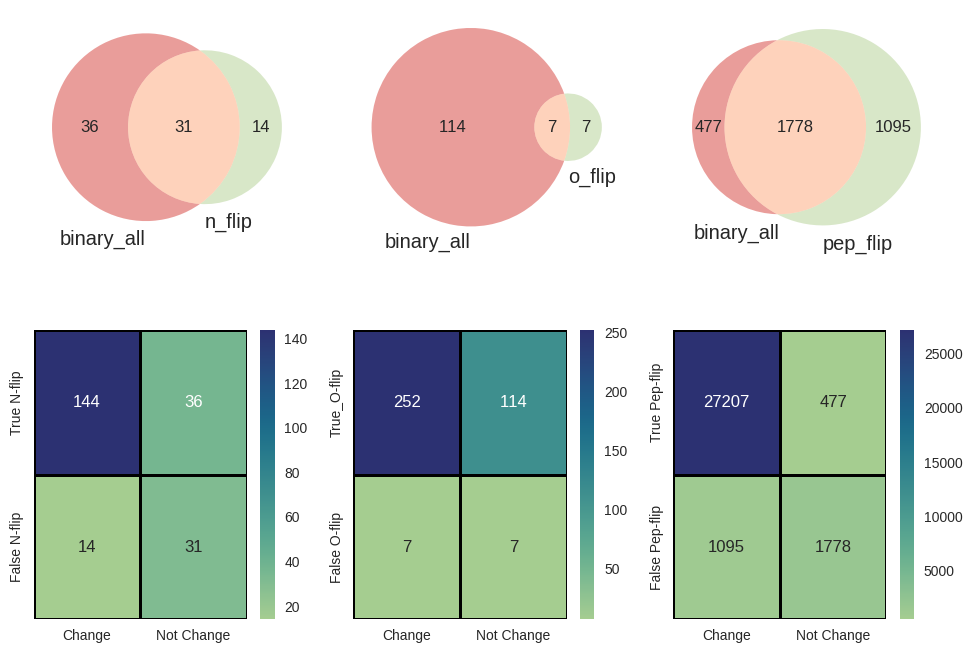

In [109]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

n_flip_overlap_venn =n_flip.groupby(["y_pred_n_flip", "y_pred_binary_all"]).size().tolist()[1:]
o_flip_overlap_venn =o_flip.groupby(["y_pred_o_flip", "y_pred_binary_all"]).size().tolist()[1:]
pep_flip_overlap_venn =pep_flip.groupby(["y_pred_pep_flip", "y_pred_binary_all"]).size().tolist()[1:]

n_flip_overlap_venn

fig, axes = plt.subplots(2,3, figsize=(11.69,8.27))


im1 = venn2(subsets = n_flip_overlap_venn, set_labels = ('binary_all', 'n_flip'), ax=axes[0][0])
im2 = venn2(subsets = o_flip_overlap_venn, set_labels = ('binary_all', 'o_flip'), ax=axes[0][1])
im3 = venn2(subsets = pep_flip_overlap_venn, set_labels = ('binary_all', 'pep_flip'), ax=axes[0][2])

im4 = sns.heatmap(n_flip_matrix, fmt='.6g' ,annot=True ,cmap='crest', linewidths=2,linecolor= 'black', ax=axes[1][0])
im5 = sns.heatmap(o_flip_matrix, fmt='.6g' ,annot=True ,cmap='crest', linewidths=2,linecolor= 'black', ax=axes[1][1])
im6 = sns.heatmap(pep_flip_matrix, fmt='.6g' ,annot=True ,cmap='crest', linewidths=2,linecolor= 'black', ax=axes[1][2])

plt.show()


Best Threshold=0.498103, G-mean=0.909


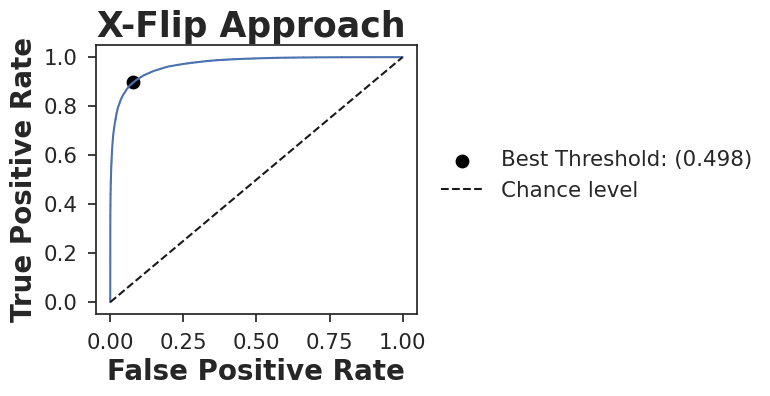

In [53]:
from matplotlib import pyplot
sns.set_theme(style="whitegrid",font_scale = 1.4)
sns.set_style("white")
sns.set_style("ticks")
yhat = clf.predict_proba(X_test)
yhat = yhat[:, 1]
# calculate pr-curve
fpr, tpr, thresholds = roc_curve(y_test, yhat)

x = np.linspace(0, 1, 1000)

gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest f score
ix = argmax(gmeans)

print('Best Threshold=%f, G-mean=%.3f' % (thresholds[ix], gmeans[ix]))

fig, ax= plt.subplots(1, 1, sharex=True, sharey=True,figsize=(4.15, 3.5))

ax.plot(fpr, tpr)
ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', s = 80,  label='Best Threshold: (%.3f)' %(thresholds[ix]))
ax.plot(x, x,'--k', label='Chance level');
ax.xaxis.set_ticks(np.arange(0, 1.1, 0.25))

handles, labels = ax.get_legend_handles_labels()
# axis labels
plt.xlabel('False Positive Rate', fontsize = 20,fontweight='bold')
plt.ylabel('True Positive Rate',fontsize = 20,fontweight='bold')
fig.suptitle(f'X-Flip Approach',fontweight='bold',fontsize = 25)
ax.legend(bbox_to_anchor=(2.1, 0.35), loc='lower right')
# show the plot
plt.show()

In [17]:
threshold = thresholds[ix]
y_pred = (clf.predict_proba(X_test)[:, 1] > threshold).astype('float')

Features selected:  ['cn_p1' 'nca_m1' 'nca_r0' 'nca_p1' 'nca_p2' 'cac_m1' 'cac_p1' 'co_r0'
 'caca_r0' 'caca_p1' 'o_o_m1' 'o_o_r0' 'o_o_p1' 'o_o_p2' 'cbcb_r0'
 'cbcb_p1' 'cbcb_p2' 'ncac_p1' 'ncac_p2' 'caco_m1' 'caco_r0' 'ocn_r0'
 'cacn_r0' 'cnca_m1' 'cnca_r0' 'cnca_p1' 'cnca_p2' 'ncacb_m1' 'ncacb_r0'
 'ncacb_p1' 'ncacb_p2' 'ccacb_p1' 'phi_r0' 'phi_p1' 'phi_p2' 'psi_r0'
 'psi_p1' 'psi_p2' 'omega_m1' 'omega_r0' 'omega_p1' 'occac_m1' 'occac_r0'
 'occac_p1' 'coco_m1' 'coco_r0' 'coco_p1' 'coco_p2' 'imp_m1' 'imp_p1'
 'imp_p2' 'bn_m1' 'bn_r0' 'bn_p1' 'bn_p2' 'bca_m1' 'bca_r0' 'bca_p1'
 'bca_p2' 'bc_m1' 'bc_r0' 'bc_p1' 'bc_p2' 'bo_m1' 'bo_r0' 'bo_p1' 'bo_p2'
 'donor_1' 'acceptor_1' 'zram_m1' 'zram_r0' 'zram_p1' 'zram_p2' 'dbond'
 'dangle' 'dphi' 'dcaca' 'dssp_m1' 'dssp_m1E' 'dssp_m1H' 'dssp_m1loop'
 'dssp_m1S' 'dssp_m1T' 'dssp_r0E' 'dssp_r0H' 'dssp_r0loop' 'dssp_r0S'
 'dssp_r0T' 'dssp_p1E' 'dssp_p1H' 'dssp_p1loop' 'dssp_p1P' 'dssp_p1S'
 'dssp_p1T' 'dssp_p2' 'dssp_p2E' 'dssp_p2H' 'dssp_p2loop' '

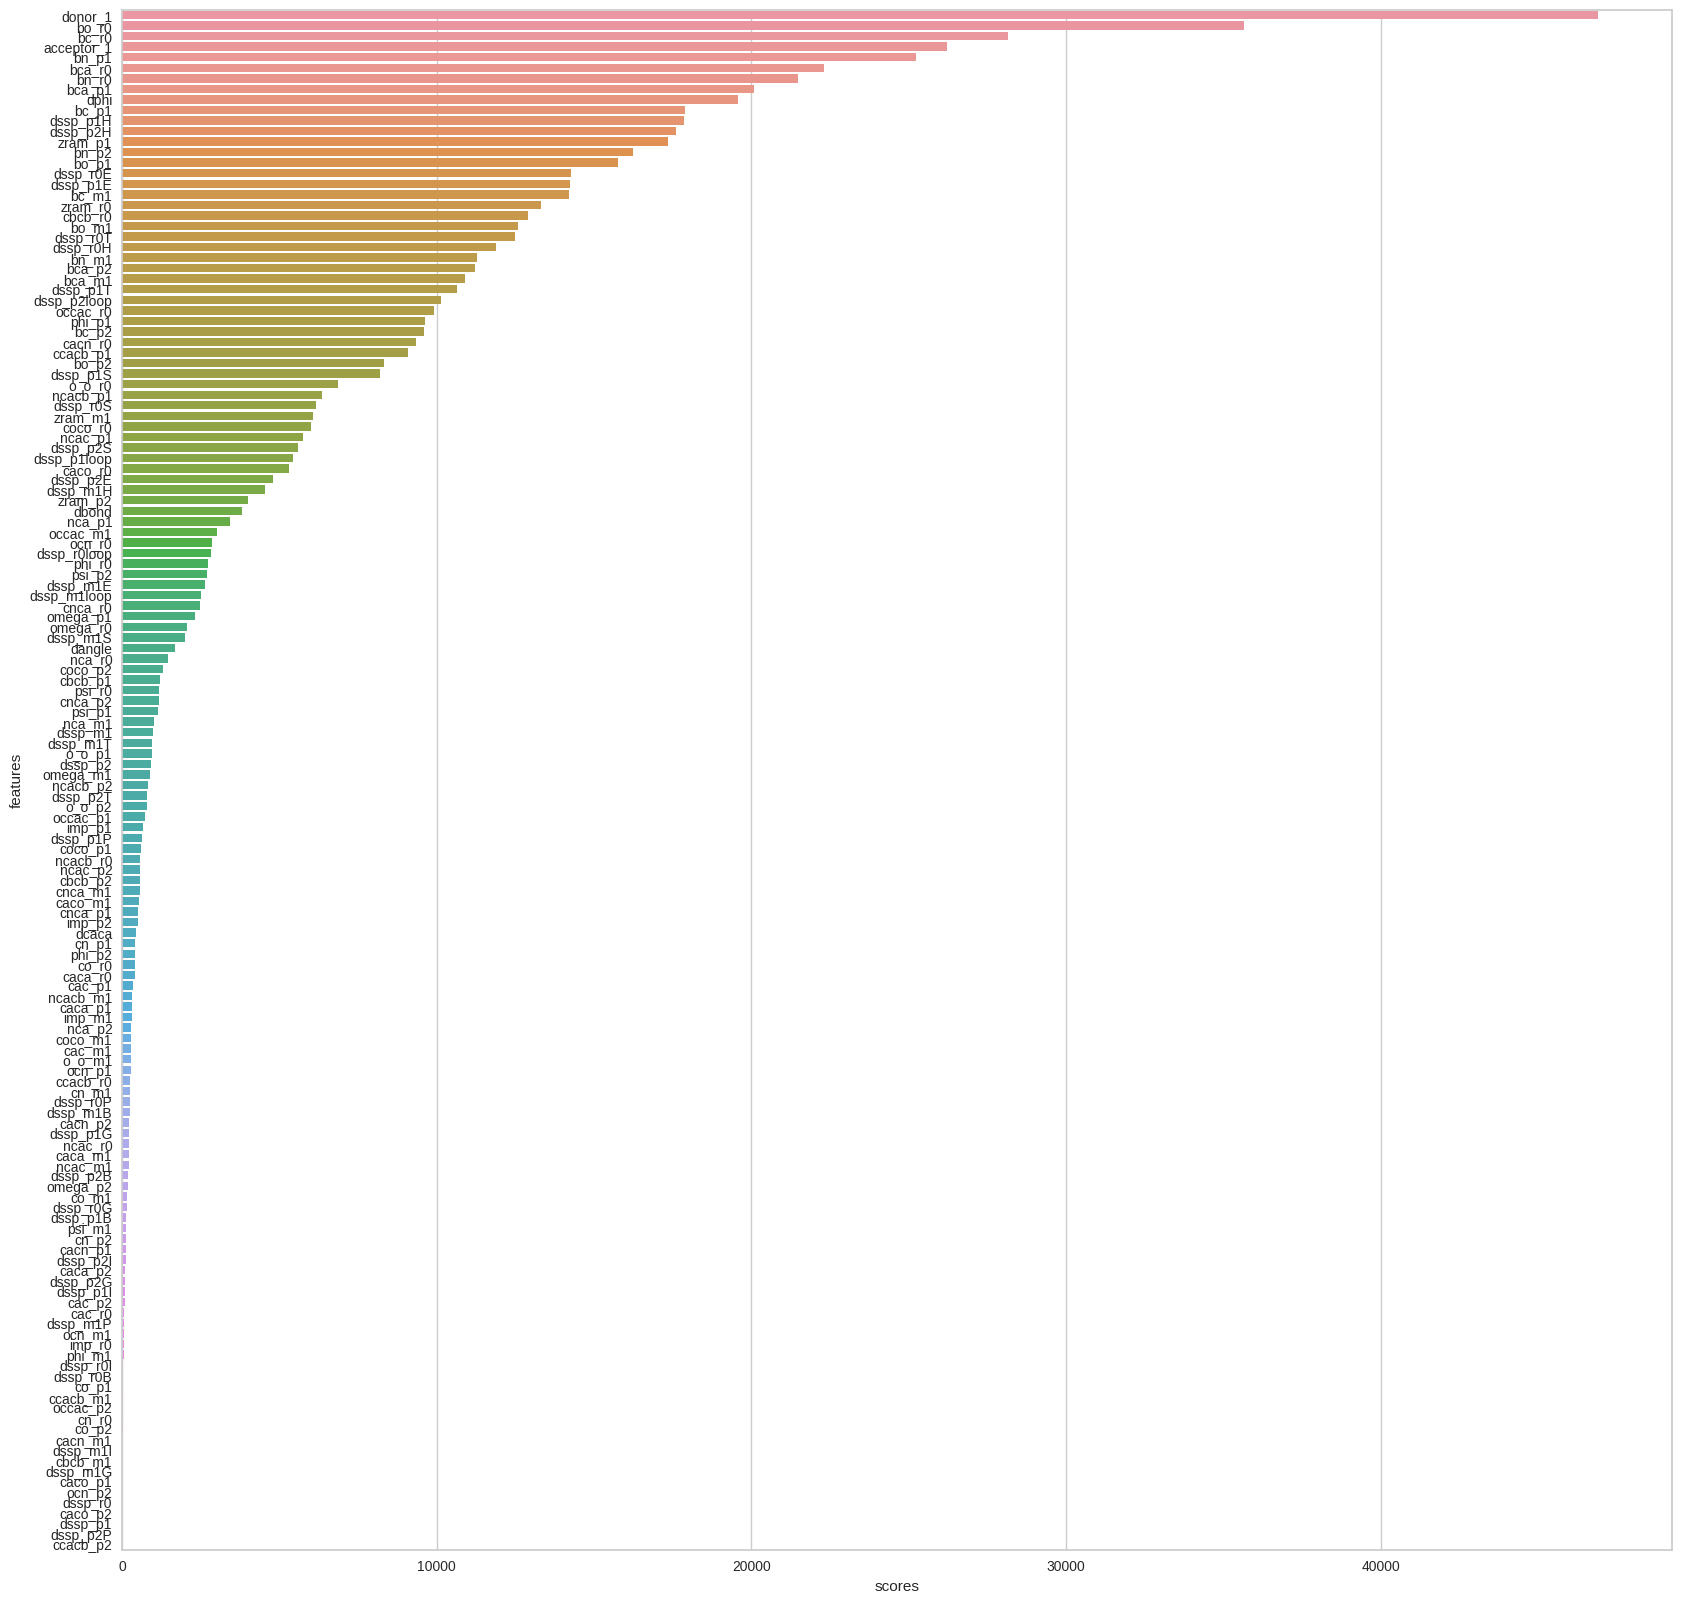

In [18]:
fs = clf.best_estimator_.named_steps['kbest']

features = np.array(X_train.columns)
selected_features = features[fs.get_support()]

print("Features selected: ", selected_features)
print("\n The best parameters across ALL searched params:\n", clf.best_params_)

scores = fs.scores_


features = list(map(str, features))

feature_importance = pd.DataFrame(list(zip(features, scores)), columns =['features', 'scores']).sort_values('scores', ascending=False)

#feature_importance = feature_importance[feature_importance['scores'] > 250]

fig = plt.figure(figsize= (20,20))
ax = sns.barplot(data=feature_importance, x="scores", y="features")
plt.show()



In [29]:
feature_importance.head(10)

,features,scores
96,donor_1,667.244413
97,acceptor_1,547.915583
93,bo_r0,537.785471
89,bc_r0,457.056326
82,bn_p1,425.184516
81,bn_r0,385.521699
50,ncacb_p1,376.973011
85,bca_r0,375.819377
104,dphi,366.933886
100,zram_p1,330.133018


In [97]:

print(classification_report(y_test, y_pred))

balanced_accuracy_score(y_test, y_pred)
#roc_auc_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91     31162
           1       0.92      0.90      0.91     31141

    accuracy                           0.91     62303
   macro avg       0.91      0.91      0.91     62303
weighted avg       0.91      0.91      0.91     62303



0.9091496169123752

TypeError: 'numpy.ndarray' object is not callable

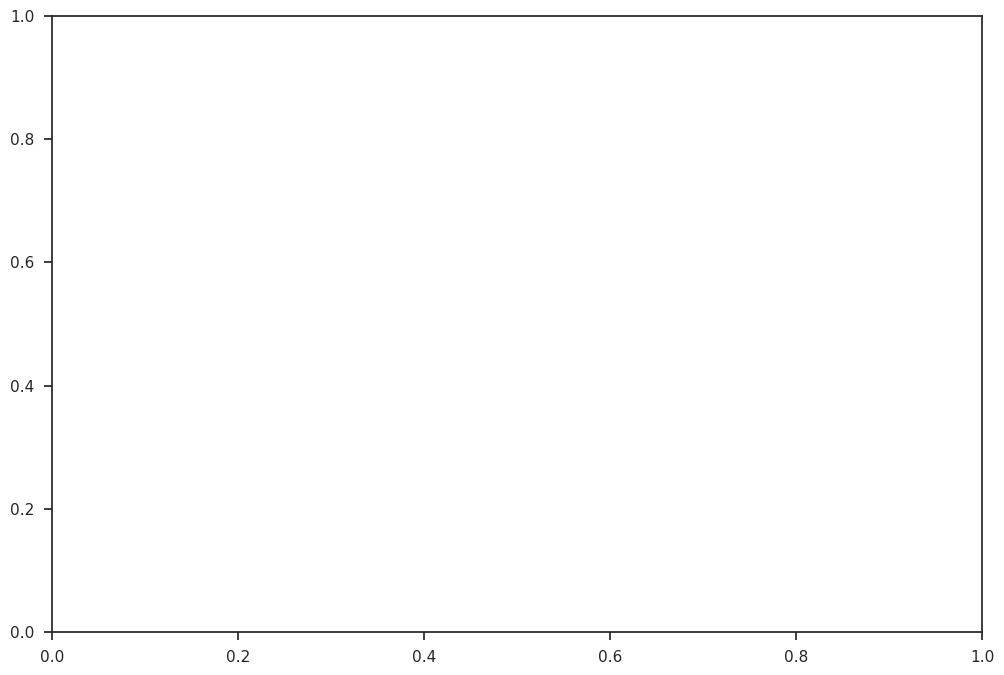

In [98]:


# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(12, 8))
# Create the matrix
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
cmp.plot(ax=ax)

plt.show();

In [13]:

classes = unique_label.sort_values(by=['encoded_label'])['conformation_type']


df_matrix = pd.DataFrame(confusion_matrix(y_test, y_pred), columns= classes, index=classes)

plt.figure(figsize = (10,7))
ax = sns.heatmap(df_matrix, fmt='.6g' ,annot=True ,cmap='crest', linewidths=2,linecolor= 'black')
plt.xlabel('Predicted label', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True label', fontsize = 15) # y-axis label with fontsize 15

plt.show()

ValueError: Shape of passed values is (2, 2), indices imply (4, 4)

In [34]:
unique_label

,conformation_type,encoded_label
0,random,3
1,pep_flip,2
2,o_flip,1
3,n_flip,0


In [46]:
y_test_info['y_pred'] = y_pred

validate_df = y_test_info

validate_df

,conformation_type,encoded_label,pdb_id,asymID,compID,insCode,seqNum,seqID_besttls,y_pred
104449,random,1,6md6,A,PRO,NaN,89,93,1
20987,random,1,3mtr,A,PHE,NaN,474,74,1
87775,random,1,5s78,B,GLY,NaN,289,91,1
114428,random,1,7a8y,B,GLY,NaN,52,28,1
13236,random,1,3e01,A,PRO,NaN,433,433,1
...,...,...,...,...,...,...,...,...,...
8071,random,1,2y73,A,GLY,NaN,309,309,0
51374,random,1,2dps,B,ASN,NaN,92,92,1
121658,random,1,7p5f,A,ALA,NaN,548,245,1
24918,random,1,3qva,A,PRO,NaN,16,22,1


In [48]:
false_negatives = validate_df[(validate_df['encoded_label'] == 0) & (validate_df['y_pred'] == 1)]
false_negatives

,conformation_type,encoded_label,pdb_id,asymID,compID,insCode,seqNum,seqID_besttls,y_pred
103376,o_flip,0,6kvo,A,SER,NaN,245,141,1
67616,o_flip,0,4u1w,A,LEU,NaN,639,632,1
12360,o_flip,0,3d0i,C,THR,NaN,402,79,1
67617,o_flip,0,4u1w,C,LYS,NaN,434,427,1
33510,o_flip,0,4biw,A,ALA,NaN,220,10,1
...,...,...,...,...,...,...,...,...,...
80838,o_flip,0,5jsz,D,ARG,NaN,63,58,1
106061,o_flip,0,6oht,A,GLY,NaN,81,68,1
75113,o_flip,0,5d4c,K,GLY,NaN,931,931,1
60396,o_flip,0,4lfb,E,ASN,NaN,127,127,1


Text(85.18576388888889, 0.5, 'True label')

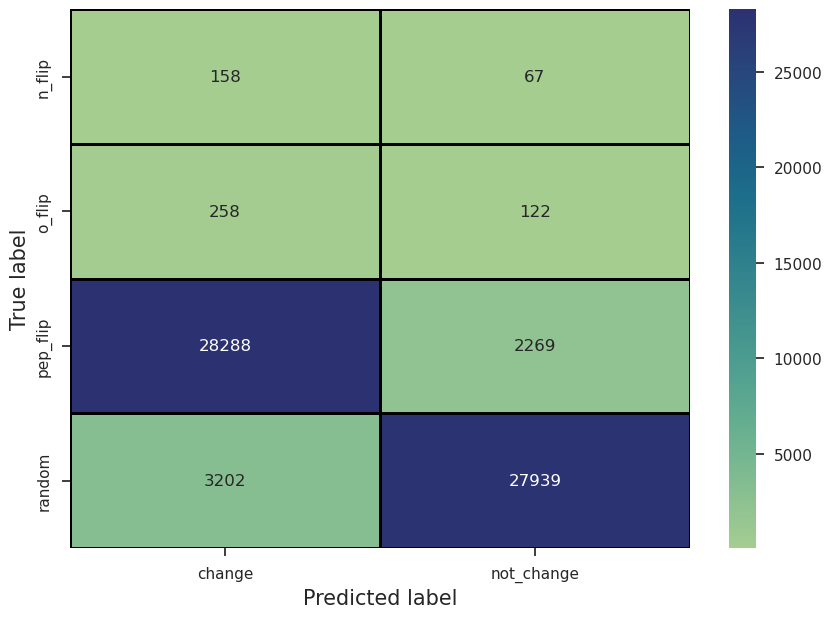

In [86]:

#binary classifier

y_test_info['y_pred'] = y_pred

action = ['change', 'not_change']

classes = unique_label.sort_values(by=['encoded_label'])['conformation_type']

confusion_matrix = y_test_info.groupby(["conformation_type", "y_pred"]).size().unstack().to_numpy()



df_matrix = pd.DataFrame(confusion_matrix, columns= action, index=classes)



plt.figure(figsize = (10,7))
ax = sns.heatmap(df_matrix, fmt='.6g' ,annot=True ,cmap='crest', linewidths=2,linecolor= 'black')
plt.xlabel('Predicted label', fontsize = 15) # x-axis label with fontsize 15
plt.ylabel('True label', fontsize = 15) # y-axis label with fontsize 15

In [94]:
prueba = y_test_info[["conformation_type", "y_pred"]]

prueba

,conformation_type,y_pred
228706,pep_flip,0.0
130914,pep_flip,0.0
156120,pep_flip,0.0
169014,random,1.0
242551,pep_flip,0.0
...,...,...
144884,random,1.0
159477,random,1.0
56386,random,1.0
84986,pep_flip,0.0


In [1]:
def print_scores(scores):
   
    models = ["KNN", "RFC", "SVM", "XGB"]

    for score, model in zip(scores, models):
        
        print()
        print(f'{model} classifier model scores:')

        print(f"CV all accuracy scores: {score[0]}")
        print(f"CV all AUC scores: {score[1]}")
        print(f"CV all F1 scores: {score[2]}")

In [31]:
scores_1 = {"acc":np.array([1,2,3,4,5]), "AUC":np.array([1,2,3,4,5]), "F1":np.array([1,2,3,4,5]), "recall":np.array([1,2,3,4,5]),"balanced_accuracy":np.array([1,2,3,4,5])}
scores_2 = {"acc":np.array([1,2,3,4,5]), "AUC":np.array([1,2,3,4,5]), "F1":np.array([1,2,3,4,5]), "recall":np.array([1,2,3,4,5]),"balanced_accuracy":np.array([1,2,3,4,5])}
scores_3 = {"acc":np.array([1,2,3,4,5]), "AUC":np.array([1,2,3,4,5]), "F1":np.array([1,2,3,4,5]), "recall":np.array([1,2,3,4,5]),"balanced_accuracy":np.array([1,2,3,4,5])}
scores_4 = {"acc":np.array([1,2,3,4,5]), "AUC":np.array([1,2,3,4,5]), "F1":np.array([1,2,3,4,5]), "recall":np.array([1,2,3,4,5]),"balanced_accuracy":np.array([1,2,3,4,5])}
models = ["KNN", "RFC", "SVM", "XGB"]
scores = [scores_1,scores_2,scores_3,scores_4]
model_dict={}
for score, model in zip(scores, models):
    if not model in model_dict:
        model_dict[model] = {"mean":{},"std":{}}
    model_dict[model]["mean"] = {k:np.mean(v) for k, v in score.items()}
    model_dict[model]["std"] = {k:np.std(v) for k, v in score.items()}
    model_dict[model]["scores"] = {k:list(v)for k, v in score.items()}
    
model_dict





{'KNN': {'mean': {'acc': 3.0,
   'AUC': 3.0,
   'F1': 3.0,
   'recall': 3.0,
   'balanced_accuracy': 3.0},
  'std': {'acc': 1.4142135623730951,
   'AUC': 1.4142135623730951,
   'F1': 1.4142135623730951,
   'recall': 1.4142135623730951,
   'balanced_accuracy': 1.4142135623730951},
  'scores': {'acc': [1, 2, 3, 4, 5],
   'AUC': [1, 2, 3, 4, 5],
   'F1': [1, 2, 3, 4, 5],
   'recall': [1, 2, 3, 4, 5],
   'balanced_accuracy': [1, 2, 3, 4, 5]}},
 'RFC': {'mean': {'acc': 3.0,
   'AUC': 3.0,
   'F1': 3.0,
   'recall': 3.0,
   'balanced_accuracy': 3.0},
  'std': {'acc': 1.4142135623730951,
   'AUC': 1.4142135623730951,
   'F1': 1.4142135623730951,
   'recall': 1.4142135623730951,
   'balanced_accuracy': 1.4142135623730951},
  'scores': {'acc': [1, 2, 3, 4, 5],
   'AUC': [1, 2, 3, 4, 5],
   'F1': [1, 2, 3, 4, 5],
   'recall': [1, 2, 3, 4, 5],
   'balanced_accuracy': [1, 2, 3, 4, 5]}},
 'SVM': {'mean': {'acc': 3.0,
   'AUC': 3.0,
   'F1': 3.0,
   'recall': 3.0,
   'balanced_accuracy': 3.0},
  'st

In [55]:


mean = {k:np.mean(v) for k, v in scores.items()}
std = {k:np.std(v) for k, v in scores.items()}

std

with open('readme.txt', 'w') as f:

    models = ["KNN", "RFC", "SVM", "XGB"]
    metrics = ["acc","AUC","F1","recall","balanced_accuracy"]

    for score, model in zip(scores, models):
   
        f.write(f'{model} classifier model scores:\n')
        f.write(f"CV all accuracy scores: {score[0]}\n")
        f.write(f"CV all AUC scores: {score[1]}\n")
        f.write(f"CV all F1 scores: {score[2]}\n")
        f.write('\n')
    

{'acc': 1.4142135623730951,
 'AUC': 1.4142135623730951,
 'F1': 1.4142135623730951,
 'recall': 1.4142135623730951,
 'balanced_accuracy': 1.4142135623730951}

In [5]:
def open_json(file):

    with open(file) as user_file:
        file_contents = user_file.read()

    parsed_json = json.loads(file_contents)
    
    return parsed_json

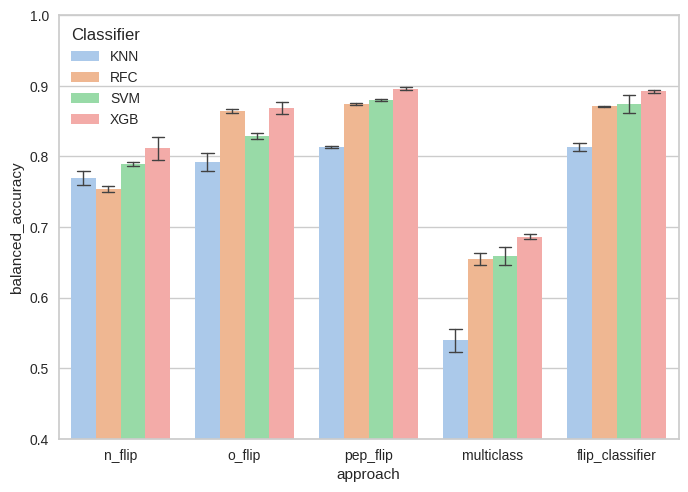

In [23]:

n_flip_dict = open_json('data/training_data/scores/training_scores_n_flip.json')
o_flip_dict = open_json('data/training_data/scores/training_scores_o_flip.json')
pep_flip_dict = open_json('data/training_data/scores/training_scores_pep_flip.json')
multiclass_dict = open_json('data/training_data/scores/training_scores_multiclass.json')
binary_dict = open_json('data/training_data/scores/training_scores_binary_all.json')

models = ["KNN", "RFC", "SVM", "XGB"]
approaches_clf = [n_flip_dict, o_flip_dict, pep_flip_dict, multiclass_dict, binary_dict]
approaches = ["n_flip", "o_flip", "pep_flip" ,"multiclass","flip_classifier"]

df_scores =pd.DataFrame()
for approach, clf in zip(approaches, approaches_clf):
    for model in models:
        tmp_df = pd.DataFrame(data=clf[model]["scores"])
        tmp_df["classifier"] = model
        tmp_df["approach"] = approach
        df_scores = pd.concat([df_scores,tmp_df])
df_scores

g = sns.barplot(data=df_scores, x="approach", y="balanced_accuracy", hue="classifier", errorbar="sd", capsize = 0.1, errwidth = 1, palette = "pastel", alpha = 1)
g.set_ylim([0.4,1])
plt.legend(title='Classifier',loc='upper left')




In [72]:
df_scores =pd.DataFrame()
for model in models:
        tmp_df = pd.DataFrame(data=n_flip_dict[model]["scores"])
        tmp_df["classifier"] = model
        df_scores = pd.concat([df_scores,tmp_df])
df_scores.shape

(20, 6)